In [31]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

#Function definition for combination 

In [32]:

# Define function that finds best model
def FindBestModel(df, target, models, scalers , encoders ) :

    # Extract X,y
    X = df.drop(target, axis=1)
    y = df[target]

    # Seperate categorical/numerical data
    X_category = X.select_dtypes(include = 'object')
    df_cateEmpty = X_category.empty
    X_num = X.select_dtypes(exclude = 'object')
    df_numEmpty = X_num.empty 
    
    # Hyperparameters for GridSearchCV
    DT_entropy_params = {'criterion':["entropy"],'max_depth':[None,2,3,4], 'min_samples_split':[2,3,4]}
    DT_gini_params = {'criterion':["gini"],'max_depth':[2,3,4], 'min_samples_split':[2,3,4]}
    LR_params = {'C': [0.01, 0.1, 1, 10],'solver':['newton-cg','lbfgs', 'liblinear', 'sag', 'saga']}
    SVC_params = { 'C': [0.01, 0.1, 1, 10],'gamma': [0.01, 0.1, 1, 10],'kernel':['linear', 'poly', 'rbf', 'sigmoid']}

    
    model_best_scaler_encoder=[]
    model_best_param=[]
    model_best_k=[]
    model_best_accuracy=[]


    for model in models:

      best_accuracy = 0
      besk_k = 0
      best_param = []
      best_scaler_encoder = []

      for scaler in scalers:

        for encoder in encoders:
          
          # Encoding and Scaling of each method
          if df_numEmpty is False and scaler!= None :
               new_df = pd.DataFrame(scaler.fit_transform(X_num))
               
          elif df_cateEmpty is False and encoder!= None:
            if encoder == OrdinalEncoder() :
                encoded = encoder.fit_transform(X_category)
                new_df = pd.concat([new_df,encoded], axis=1)

            elif encoder == OneHotEncoder() :
                encoded = pd.DataFrame(pd.get_dummies(X_category))
                new_df = pd.concat([new_df, encoded], axis=1)
          else:
               new_df = X
        
          #print(model,scaler,encoder,'\n',new_df)
    
          # Train, Test set split        
          X_train, X_test, y_train, y_test = train_test_split(new_df,y,test_size=0.3, shuffle=True, random_state=10)
          

          # GridSearchCV for each model
          # Cross validation with different k values

          for k in range(3,10):
            
            if model == DecisionTreeEntropy:
                gridsearch = GridSearchCV(model, param_grid=DT_entropy_params, cv=k)

            elif model == DecisionTreeGini:
                gridsearch = GridSearchCV(model, param_grid=DT_gini_params, cv=k)

            elif model == SVC:
                gridsearch = GridSearchCV(model, param_grid=SVC_params, cv=k)

            elif model == LogisticRegression:
                gridsearch = GridSearchCV(model, param_grid=LR_params, cv=k)

            gridsearch.fit(X_train, y_train)
            score = gridsearch.score(X_test, y_test)

            # Update best model
            if score > best_accuracy:
                best_accuracy = score
                best_param = gridsearch.best_params_
                best_scaler_encoder = [scaler,encoder]
                best_k = k
                
      # Save best combination of each models
      model_best_scaler_encoder.append(best_scaler_encoder)
      model_best_param.append(best_param)
      model_best_k.append(best_k)
      model_best_accuracy.append(best_accuracy)
      

    # Create dataframe to save results
    result_df = pd.DataFrame({
                              'Best scaling and encoding method':model_best_scaler_encoder,
                              'Best model parameters':model_best_param,
                              'Best k value':model_best_k,
                              'Best accuracy':model_best_accuracy},
                              index=['DecisionTreeEntropy', 'DecisionTreeGini', 'SVC', 'LogisticRegression'])  

    return result_df


#Main of source code

In [33]:
# Read dataset
df = pd.read_csv('dataset/breast-cancer-wisconsin.data')

df.columns = ['id','thickness','size_uniformity','shape_uniformity','adhesion','epithelial_size',
              'bare_nucleoli','bland_chromatin','normal_nucleoli','mitoses','class']

##Data exploration

In [34]:
#statistics about data
df.describe()  

,id,thickness,size_uniformity,shape_uniformity,adhesion,epithelial_size,bland_chromatin,normal_nucleoli,mitoses,class
count,6.980000e+02,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000
mean,1.071807e+06,4.416905,3.137536,3.210602,2.809456,3.217765,3.438395,2.869628,1.590258,2.690544
std,6.175323e+05,2.817673,3.052575,2.972867,2.856606,2.215408,2.440056,3.055004,1.716162,0.951596
min,6.163400e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.702582e+05,2.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171710e+06,4.000000,1.000000,1.000000,1.000000,2.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238354e+06,6.000000,5.000000,5.000000,4.000000,4.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [35]:
# Check value distribution for each features
for i in df.columns:
    print('Value distribution of',i)
    print(df[i].value_counts(sort=True, ascending=False))
    print('\n\n')


Value distribution of id
1182404    6
1276091    5
1198641    3
897471     2
1114570    2
          ..
1236043    1
1241232    1
1241559    1
1241679    1
814911     1
Name: id, Length: 644, dtype: int64



Value distribution of thickness
1     145
5     129
3     108
4      80
10     69
2      50
8      46
6      34
7      23
9      14
Name: thickness, dtype: int64



Value distribution of size_uniformity
1     383
10     67
3      52
2      45
4      40
5      30
8      29
6      27
7      19
9       6
Name: size_uniformity, dtype: int64



Value distribution of shape_uniformity
1     352
2      59
10     58
3      56
4      44
5      34
6      30
7      30
8      28
9       7
Name: shape_uniformity, dtype: int64



Value distribution of adhesion
1     406
3      58
2      58
10     55
4      33
8      25
5      23
6      22
7      13
9       5
Name: adhesion, dtype: int64



Value distribution of epithelial_size
2     385
3      72
4      48
1      47
6      41
5      39
10     31
8

##Dirty data cleaning

###Feature 'bare_nucleoli' has wrong values '?'
  *   Drop records with value '?'
  





In [36]:
# preprocessing
df['bare_nucleoli'] = df['bare_nucleoli'].astype('category')
idx = df[df['bare_nucleoli'] == '?'].index
df_temp = df.drop(idx)



##Feature engineering
###Plot correlation matrix

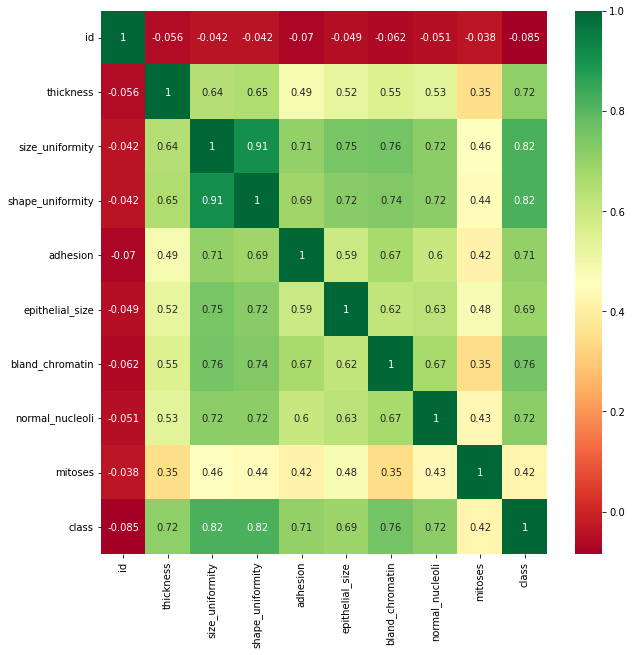

In [37]:
#get correlations of features in the dataset
corrmat = df_temp.corr() #corr() computes pairwise correlations of features in a DataFrame
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot the heat map
g=sns.heatmap(df_temp[top_corr_features].corr(),annot=
True,cmap="RdYlGn")

###Feature 'ID' doesn't have correlation with target
  *   Drop feature 'id'

In [38]:
# drop id column
df_temp = df_temp.drop(['id'], axis = 1)


##Prepare combination list for scaling, encoding and models

In [39]:
# Define scalers,encoders,models for combinations 
scalerList= [None, StandardScaler(), MinMaxScaler(), MaxAbsScaler(), RobustScaler()]
encoderList= [None, OrdinalEncoder(), OneHotEncoder()]

# Define model list
DecisionTreeEntropy = DecisionTreeClassifier()
DecisionTreeGini = DecisionTreeClassifier()
SVC = SVC()
LogisticRegression = LogisticRegression()
modelList = [DecisionTreeEntropy, DecisionTreeGini, SVC, LogisticRegression]

#Call function for analysis
result=FindBestModel(df_temp, 'class', modelList, scalerList,encoderList)


##Analysis result

In [40]:
result

,Best scaling and encoding method,Best model parameters,Best k value,Best accuracy
DecisionTreeEntropy,"[StandardScaler(), OrdinalEncoder()]","{'criterion': 'entropy', 'max_depth': None, 'm...",4,0.965854
DecisionTreeGini,"[StandardScaler(), None]","{'criterion': 'gini', 'max_depth': 4, 'min_sam...",6,0.960976
SVC,"[None, None]","{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}",3,0.980488
LogisticRegression,"[RobustScaler(), None]","{'C': 0.01, 'solver': 'liblinear'}",3,0.985366
